# Telcom Customer Churn Prediction - Model Training & MLflow Deployment

This notebook implements a complete MLOps pipeline for telcom customer churn prediction, including model training, evaluation, hyperparameter tuning, and MLflow deployment.

## Project Overview
- **Objective**: Build and deploy machine learning models to predict customer churn
- **Input Data**: Cleaned dataset from EDA notebook (cleaned_telcom_data.csv)
- **MLflow Integration**: Complete experiment tracking and model registry
- **Target Metric**: Prioritize Recall (catching churners) and AUC-ROC

## Notebook Structure
1. Setup & Data Loading
2. Data Splitting
3. Baseline Model: Logistic Regression
4. Advanced Models Training
5. Hyperparameter Tuning
6. Model Evaluation & Visualization
7. Final Model Selection
8. MLflow Integration & Logging
9. Model Registry & Deployment
10. Business Insights & Feature Analysis

## 1. Setup & Data Loading

In [20]:
# Install required packages
# %pip install mlflow xgboost lightgbm scikit-learn pandas numpy matplotlib seaborn --quiet

In [21]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import pickle
from datetime import datetime

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                           roc_auc_score, classification_report, confusion_matrix, roc_curve)
from sklearn.preprocessing import StandardScaler

# Advanced ML libraries
import xgboost as xgb
import lightgbm as lgb

# MLflow for experiment tracking and model registry
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.lightgbm
from mlflow.tracking import MlflowClient

# Set random seeds for reproducibility
np.random.seed(42)

# Configure warnings and display settings
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

print(" All libraries imported successfully!")
print(f" Pandas version: {pd.__version__}")
print(f" Scikit-learn available")
print(f" XGBoost version: {xgb.__version__}")
print(f" LightGBM version: {lgb.__version__}")
print(f" MLflow version: {mlflow.__version__}")

 All libraries imported successfully!
 Pandas version: 2.3.3
 Scikit-learn available
 XGBoost version: 3.0.5
 LightGBM version: 4.6.0
 MLflow version: 3.5.0


In [22]:
# Configure MLflow
mlflow.set_experiment("telcom_churn_prediction")

# Get experiment info
experiment = mlflow.get_experiment_by_name("telcom_churn_prediction")
print(f" MLflow Experiment ID: {experiment.experiment_id}")
print(f" MLflow Tracking URI: {mlflow.get_tracking_uri()}")

# Create directories for artifacts if they don't exist
os.makedirs("artifacts", exist_ok=True)
os.makedirs("models", exist_ok=True)



 MLflow Experiment ID: 444754456109301605
 MLflow Tracking URI: file:///c:/Users/Admin/Documents/ML_Engineering/Churn_Prediction/mlruns


In [23]:
# Load the cleaned dataset from EDA notebook
df = pd.read_csv('cleaned_telcom_data.csv')
print(" Dataset loaded successfully!")
print(f" Dataset shape: {df.shape}")
print(f" Columns: {df.shape[1]} features")

# Display basic information about the dataset
print(f"\n Dataset Overview:")
print(f"   • Total records: {len(df):,}")
print(f"   • Total features: {df.shape[1]}")
print(f"   • Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Check for any missing values
missing_values = df.isnull().sum().sum()
print(f"   • Missing values: {missing_values}")

# Display first few rows
print(f"\n First 3 rows:")
df.head(3)

 Dataset loaded successfully!
 Dataset shape: (7043, 38)
 Columns: 38 features

 Dataset Overview:
   • Total records: 7,043
   • Total features: 38
   • Memory usage: 1.57 MB
   • Missing values: 0

 First 3 rows:


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,ChargeRatio,ServiceCount,HasPhoneService,HasInternetService,MultipleLines_Yes,MultipleLines_No,OnlineSecurity_Yes,OnlineSecurity_No,OnlineBackup_Yes,OnlineBackup_No,DeviceProtection_Yes,DeviceProtection_No,TechSupport_Yes,TechSupport_No,StreamingTV_Yes,StreamingTV_No,StreamingMovies_Yes,StreamingMovies_No,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,TenureBucket_13-24_months,TenureBucket_25-48_months,TenureBucket_49+_months
0,0,0,1,0,1,0,1,29.85,29.85,0,1.000000,1,0,1,0,0,0,1,1,0,0,1,0,1,0,1,0,1,False,False,False,False,False,True,False,False,False,False
1,1,0,0,0,34,1,0,56.95,1889.50,0,1.024768,3,1,1,0,1,1,0,0,1,1,0,0,1,0,1,0,1,False,False,True,False,False,False,True,False,True,False
2,1,0,0,0,2,1,1,53.85,108.15,1,0.995839,3,1,1,0,1,1,0,1,0,0,1,0,1,0,1,0,1,False,False,False,False,False,False,True,False,False,False


In [24]:
# Separate features (X) and target (y)

X = df.drop('Churn', axis=1)
y = df['Churn']

# Display feature and target information
print(f"\n Target Variable (Churn) Distribution:")
churn_dist = y.value_counts()
churn_pct = y.value_counts(normalize=True) * 100
for label, count in churn_dist.items():
    print(f"   • {label}: {count:,} customers ({churn_pct[label]:.2f}%)")

print(f"\n Feature Set:")
print(f"   • Number of features: {X.shape[1]}")
print(f"   • Feature data types:")
for dtype in X.dtypes.value_counts().items():
    print(f"     - {dtype[0]}: {dtype[1]} features")

print(f"\n Feature names:")
feature_names = list(X.columns)
for i, feature in enumerate(feature_names, 1):
    print(f"   {i:2d}. {feature}")

# Verify data quality
print(f"\n Data Quality Check:")
print(f"   • Features missing values: {X.isnull().sum().sum()}")
print(f"   • Target missing values: {y.isnull().sum()}")
print(f"   • Duplicate rows: {X.duplicated().sum()}")



 Target Variable (Churn) Distribution:
   • 0: 5,174 customers (73.46%)
   • 1: 1,869 customers (26.54%)

 Feature Set:
   • Number of features: 37
   • Feature data types:
     - int64: 24 features
     - bool: 10 features
     - float64: 3 features

 Feature names:
    1. gender
    2. SeniorCitizen
    3. Partner
    4. Dependents
    5. tenure
    6. PhoneService
    7. PaperlessBilling
    8. MonthlyCharges
    9. TotalCharges
   10. ChargeRatio
   11. ServiceCount
   12. HasPhoneService
   13. HasInternetService
   14. MultipleLines_Yes
   15. MultipleLines_No
   16. OnlineSecurity_Yes
   17. OnlineSecurity_No
   18. OnlineBackup_Yes
   19. OnlineBackup_No
   20. DeviceProtection_Yes
   21. DeviceProtection_No
   22. TechSupport_Yes
   23. TechSupport_No
   24. StreamingTV_Yes
   25. StreamingTV_No
   26. StreamingMovies_Yes
   27. StreamingMovies_No
   28. InternetService_Fiber optic
   29. InternetService_No
   30. Contract_One year
   31. Contract_Two year
   32. PaymentMetho

## 2. Data Splitting

In [25]:
# Split data: 70% train, 15% validation, 15% test
# First split: 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Second split: 15% validation, 15% test (from the 30% temp)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)
print(f"\n Dataset Split Summary:")
print(f"   • Training set:   {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   • Validation set: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"   • Test set:       {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"   • Total:          {len(X):,} samples")

# Verify stratification worked correctly
print(f"\n Churn Rate Distribution Across Splits:")
train_churn_rate = y_train.mean() * 100
val_churn_rate = y_val.mean() * 100
test_churn_rate = y_test.mean() * 100
overall_churn_rate = y.mean() * 100

print(f"   • Overall:    {overall_churn_rate:.2f}%")
print(f"   • Training:   {train_churn_rate:.2f}%")
print(f"   • Validation: {val_churn_rate:.2f}%")
print(f"   • Test:       {test_churn_rate:.2f}%")

# Check if splits are balanced (should be within 1% of overall rate)
max_deviation = max(abs(train_churn_rate - overall_churn_rate), 
                   abs(val_churn_rate - overall_churn_rate),
                   abs(test_churn_rate - overall_churn_rate))

if max_deviation < 1.0:
    print(" Stratification successful - all splits within 1% of overall churn rate")
else:
    print(f" Warning: Maximum deviation from overall rate: {max_deviation:.2f}%")

# Store split information for later use
split_info = {
    'train_size': len(X_train),
    'val_size': len(X_val),
    'test_size': len(X_test),
    'train_churn_rate': train_churn_rate,
    'val_churn_rate': val_churn_rate,
    'test_churn_rate': test_churn_rate,
    'overall_churn_rate': overall_churn_rate,
    'random_state': 42
}




 Dataset Split Summary:
   • Training set:   4,930 samples (70.0%)
   • Validation set: 1,056 samples (15.0%)
   • Test set:       1,057 samples (15.0%)
   • Total:          7,043 samples

 Churn Rate Distribution Across Splits:
   • Overall:    26.54%
   • Training:   26.53%
   • Validation: 26.52%
   • Test:       26.58%
 Stratification successful - all splits within 1% of overall churn rate


## 3. Baseline Model: Logistic Regression

In [26]:
# Define utility functions for model evaluation
def evaluate_model(model, X_val, y_val, model_name="Model"):
    """
    Comprehensive model evaluation function
    Returns dictionary with all metrics and predictions
    """
    # Make predictions
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    
    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_val, y_pred),
        'precision': precision_score(y_val, y_pred),
        'recall': recall_score(y_val, y_pred),
        'f1': f1_score(y_val, y_pred),
        'auc_roc': roc_auc_score(y_val, y_pred_proba)
    }
    
    # Print evaluation results
    print(f"\n {model_name} Performance Metrics:")
    print(f"   • Accuracy:  {metrics['accuracy']:.4f}")
    print(f"   • Precision: {metrics['precision']:.4f}")
    print(f"   • Recall:    {metrics['recall']:.4f}")
    print(f"   • F1-Score:  {metrics['f1']:.4f}")
    print(f"   • AUC-ROC:   {metrics['auc_roc']:.4f}")
    
    return metrics, y_pred, y_pred_proba

def plot_confusion_matrix(y_true, y_pred, model_name, save_path=None):
    """Create and display confusion matrix heatmap"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Churn', 'Churn'],
                yticklabels=['No Churn', 'Churn'])
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    return cm

def plot_roc_curve(y_true, y_pred_proba, model_name, save_path=None):
    """Create and display ROC curve"""
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc_score = roc_auc_score(y_true, y_pred_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, linewidth=2, label=f'{model_name} (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    return fpr, tpr, auc_score


 Logistic Regression model trained successfully!

 Logistic Regression Performance Metrics:
   • Accuracy:  0.8087
   • Precision: 0.6598
   • Recall:    0.5750
   • F1-Score:  0.6145
   • AUC-ROC:   0.8469

 Generating evaluation visualizations...


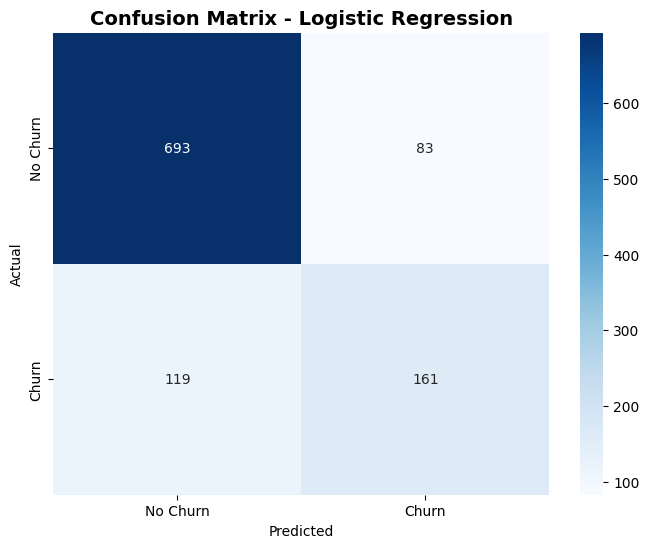

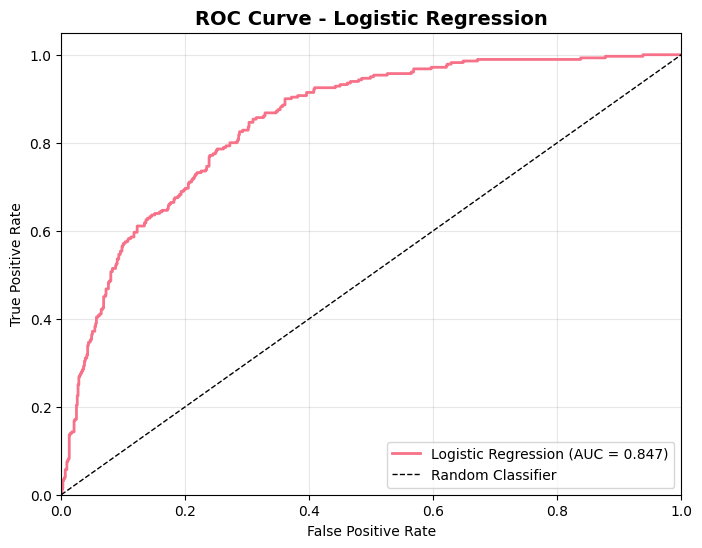

2025/10/21 12:38:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 12:38:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 MLflow logging completed!
 Run ID: 517d26ca643a4185a28a5ab82bc548df

 Detailed Classification Report:
              precision    recall  f1-score   support

    No Churn       0.85      0.89      0.87       776
       Churn       0.66      0.57      0.61       280

    accuracy                           0.81      1056
   macro avg       0.76      0.73      0.74      1056
weighted avg       0.80      0.81      0.80      1056



In [27]:
# Train Logistic Regression Baseline Model

# Start MLflow run for baseline model
with mlflow.start_run(run_name="logistic_regression_baseline") as run:
    
    # Initialize and train the model
    lr_model = LogisticRegression(random_state=42, max_iter=1000)
    lr_model.fit(X_train, y_train)
    
    print(" Logistic Regression model trained successfully!")
    
    # Evaluate the model
    lr_metrics, lr_pred, lr_pred_proba = evaluate_model(lr_model, X_val, y_val, "Logistic Regression")
    
    # Log parameters
    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_param("random_state", 42)
    mlflow.log_param("max_iter", 1000)
    mlflow.log_param("train_size", len(X_train))
    mlflow.log_param("val_size", len(X_val))
    
    # Log metrics
    for metric_name, metric_value in lr_metrics.items():
        mlflow.log_metric(metric_name, metric_value)
    
    # Log split information
    for key, value in split_info.items():
        mlflow.log_metric(f"split_{key}", value)
    
    # Add tags
    mlflow.set_tags({
        "model_type": "classification",
        "dataset": "telcom",
        "version": "1.0",
        "stage": "baseline"
    })
    
    # Generate and save visualizations
    print("\n Generating evaluation visualizations...")
    
    # Confusion Matrix
    cm_path = "artifacts/lr_confusion_matrix.png"
    cm = plot_confusion_matrix(y_val, lr_pred, "Logistic Regression", cm_path)
    mlflow.log_artifact(cm_path)
    
    # ROC Curve
    roc_path = "artifacts/lr_roc_curve.png"
    fpr, tpr, auc_score = plot_roc_curve(y_val, lr_pred_proba, "Logistic Regression", roc_path)
    mlflow.log_artifact(roc_path)
    
    # Log the model
    mlflow.sklearn.log_model(lr_model, "model")
    
    # Store run info for comparison
    lr_run_id = run.info.run_id
    
    print(f" MLflow logging completed!")
    print(f" Run ID: {lr_run_id}")

# Display classification report
print(f"\n Detailed Classification Report:")
print(classification_report(y_val, lr_pred, target_names=['No Churn', 'Churn']))

## 4. Advanced Models Training

 Training Random Forest Model...
 Random Forest model trained successfully!

 Random Forest Performance Metrics:
   • Accuracy:  0.7973
   • Precision: 0.6422
   • Recall:    0.5321
   • F1-Score:  0.5820
   • AUC-ROC:   0.8377

 Generating Random Forest visualizations...


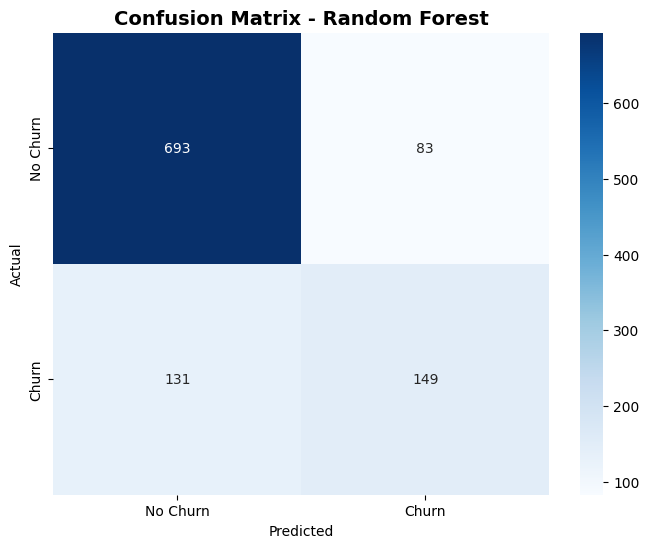

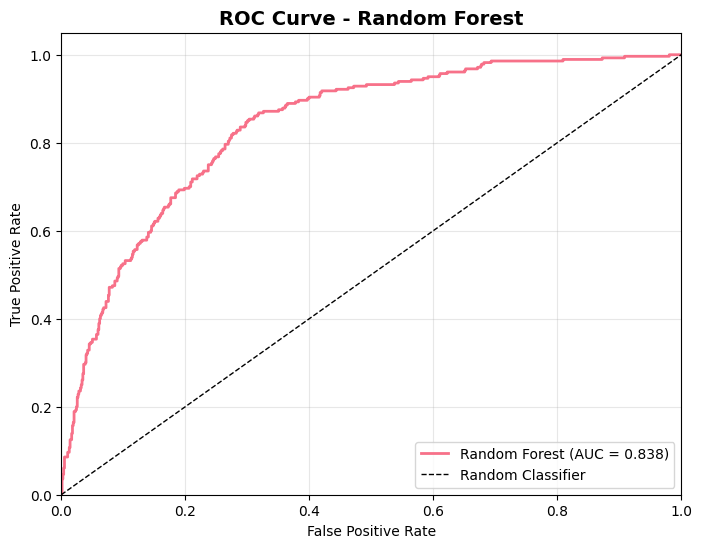

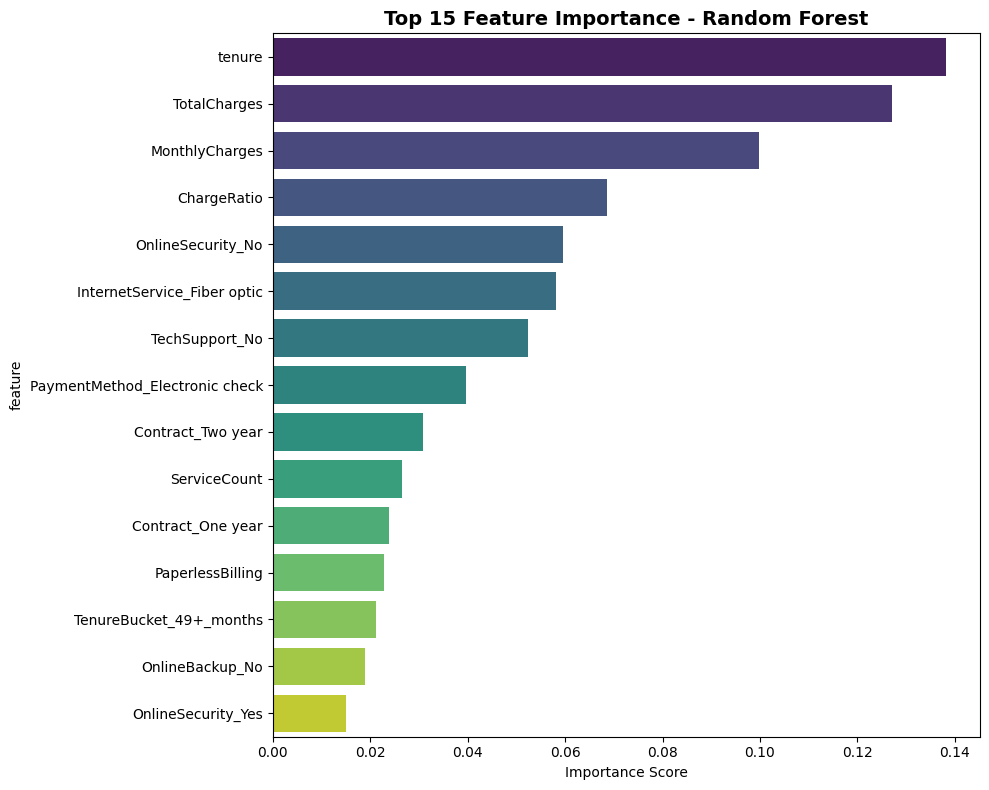

2025/10/21 12:38:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 12:39:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Random Forest MLflow logging completed! Run ID: 7dd6c3dfa56646fc9d2b3d84b02578c9


In [28]:
# Train Random Forest Model
print(" Training Random Forest Model...")

with mlflow.start_run(run_name="random_forest") as run:
    
    # Initialize and train Random Forest
    rf_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )
    rf_model.fit(X_train, y_train)
    
    print(" Random Forest model trained successfully!")
    
    # Evaluate the model
    rf_metrics, rf_pred, rf_pred_proba = evaluate_model(rf_model, X_val, y_val, "Random Forest")
    
    # Log parameters
    mlflow.log_param("model_type", "RandomForest")
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("max_depth", 10)
    mlflow.log_param("random_state", 42)
    mlflow.log_param("train_size", len(X_train))
    mlflow.log_param("val_size", len(X_val))
    
    # Log metrics
    for metric_name, metric_value in rf_metrics.items():
        mlflow.log_metric(metric_name, metric_value)
    
    # Add tags
    mlflow.set_tags({
        "model_type": "classification",
        "dataset": "telcom",
        "version": "1.0",
        "stage": "advanced",
        "algorithm": "random_forest"
    })
    
    # Generate and save visualizations
    print("\n Generating Random Forest visualizations...")
    
    # Confusion Matrix
    cm_path = "artifacts/rf_confusion_matrix.png"
    plot_confusion_matrix(y_val, rf_pred, "Random Forest", cm_path)
    mlflow.log_artifact(cm_path)
    
    # ROC Curve
    roc_path = "artifacts/rf_roc_curve.png"
    plot_roc_curve(y_val, rf_pred_proba, "Random Forest", roc_path)
    mlflow.log_artifact(roc_path)
    
    # Feature Importance Plot
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 8))
    top_features = feature_importance.head(15)
    sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
    plt.title('Top 15 Feature Importance - Random Forest', fontsize=14, fontweight='bold')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    
    fi_path = "artifacts/rf_feature_importance.png"
    plt.savefig(fi_path, dpi=300, bbox_inches='tight')
    mlflow.log_artifact(fi_path)
    plt.show()
    
    # Log the model
    mlflow.sklearn.log_model(rf_model, "model")
    
    rf_run_id = run.info.run_id
    print(f" Random Forest MLflow logging completed! Run ID: {rf_run_id}")

# Store results for comparison
rf_results = {
    'model_name': 'Random Forest',
    'metrics': rf_metrics,
    'run_id': rf_run_id,
    'model': rf_model
}

 Training XGBoost Model...
 XGBoost model trained successfully!

 XGBoost Performance Metrics:
   • Accuracy:  0.7831
   • Precision: 0.6041
   • Recall:    0.5286
   • F1-Score:  0.5638
   • AUC-ROC:   0.8383

 Generating XGBoost visualizations...


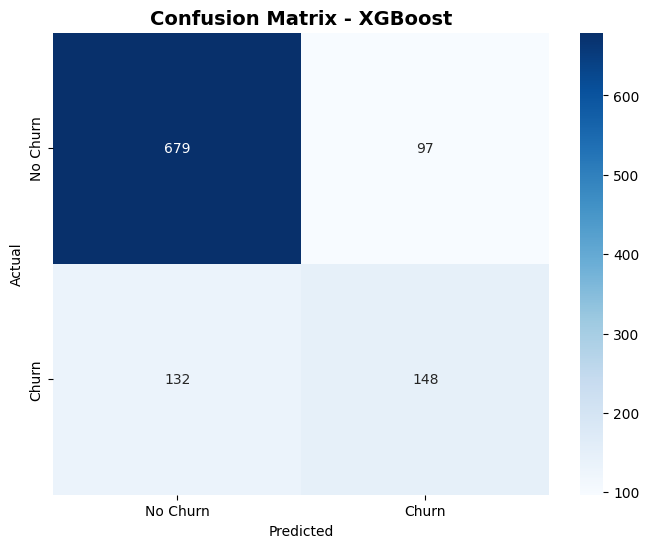

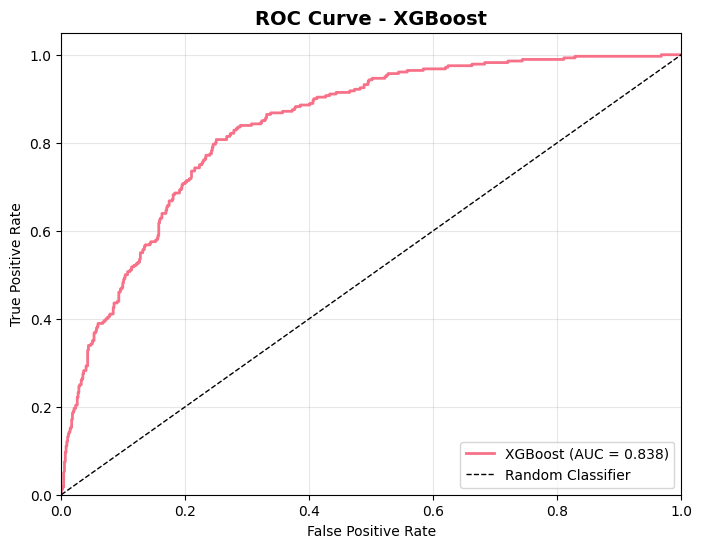

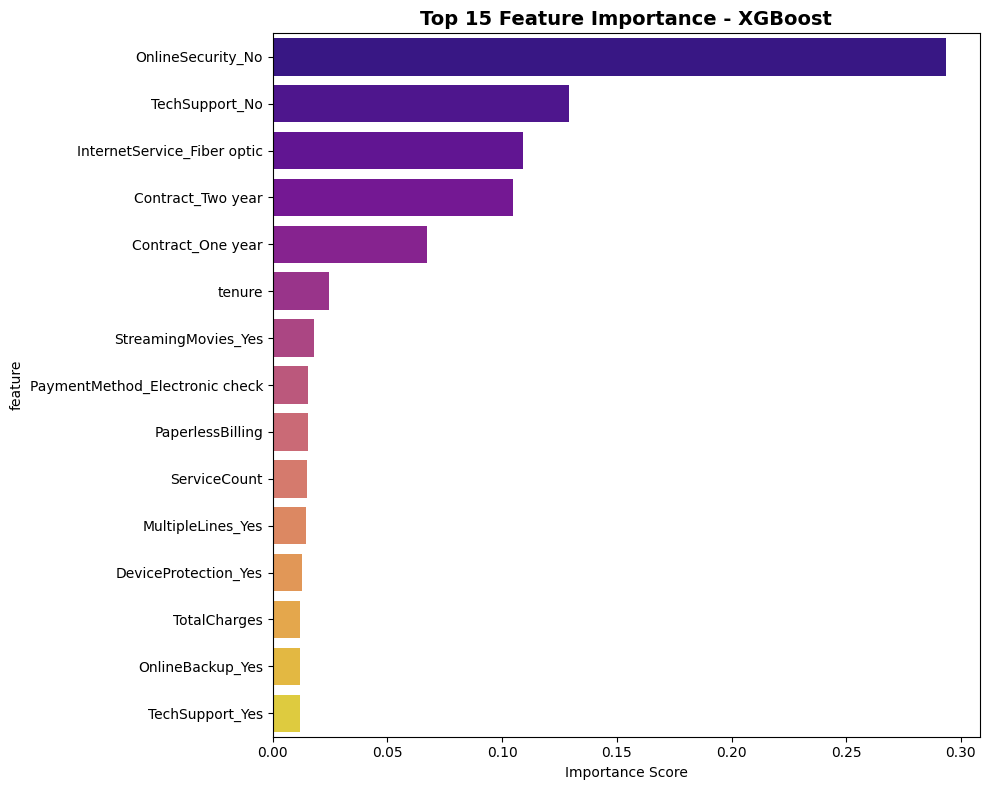

2025/10/21 12:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 12:39:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 XGBoost MLflow logging completed! Run ID: 84ce9d432c564bf38ecefc05cb8a1b75


In [29]:
# Train XGBoost Model
print(" Training XGBoost Model...")

with mlflow.start_run(run_name="xgboost") as run:
    
    # Initialize and train XGBoost
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False
    )
    xgb_model.fit(X_train, y_train)

    print(" XGBoost model trained successfully!")

    # Evaluate the model
    xgb_metrics, xgb_pred, xgb_pred_proba = evaluate_model(xgb_model, X_val, y_val, "XGBoost")
    
    # Log parameters
    mlflow.log_param("model_type", "XGBoost")
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("learning_rate", 0.1)
    mlflow.log_param("max_depth", 6)
    mlflow.log_param("random_state", 42)
    mlflow.log_param("train_size", len(X_train))
    mlflow.log_param("val_size", len(X_val))
    
    # Log metrics
    for metric_name, metric_value in xgb_metrics.items():
        mlflow.log_metric(metric_name, metric_value)
    
    # Add tags
    mlflow.set_tags({
        "model_type": "classification",
        "dataset": "telcom",
        "version": "1.0",
        "stage": "advanced",
        "algorithm": "xgboost"
    })
    
    # Generate and save visualizations
    print("\n Generating XGBoost visualizations...")
    
    # Confusion Matrix
    cm_path = "artifacts/xgb_confusion_matrix.png"
    plot_confusion_matrix(y_val, xgb_pred, "XGBoost", cm_path)
    mlflow.log_artifact(cm_path)
    
    # ROC Curve
    roc_path = "artifacts/xgb_roc_curve.png"
    plot_roc_curve(y_val, xgb_pred_proba, "XGBoost", roc_path)
    mlflow.log_artifact(roc_path)
    
    # Feature Importance Plot
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 8))
    top_features = feature_importance.head(15)
    sns.barplot(data=top_features, x='importance', y='feature', palette='plasma')
    plt.title('Top 15 Feature Importance - XGBoost', fontsize=14, fontweight='bold')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    
    fi_path = "artifacts/xgb_feature_importance.png"
    plt.savefig(fi_path, dpi=300, bbox_inches='tight')
    mlflow.log_artifact(fi_path)
    plt.show()
    
    # Log the model
    mlflow.xgboost.log_model(xgb_model, "model")
    
    xgb_run_id = run.info.run_id
    print(f" XGBoost MLflow logging completed! Run ID: {xgb_run_id}")

# Store results for comparison
xgb_results = {
    'model_name': 'XGBoost',
    'metrics': xgb_metrics,
    'run_id': xgb_run_id,
    'model': xgb_model
}

 Training LightGBM Model...
✅ LightGBM model trained successfully!

 LightGBM Performance Metrics:
   • Accuracy:  0.7860
   • Precision: 0.6098
   • Recall:    0.5357
   • F1-Score:  0.5703
   • AUC-ROC:   0.8442

 Generating LightGBM visualizations...


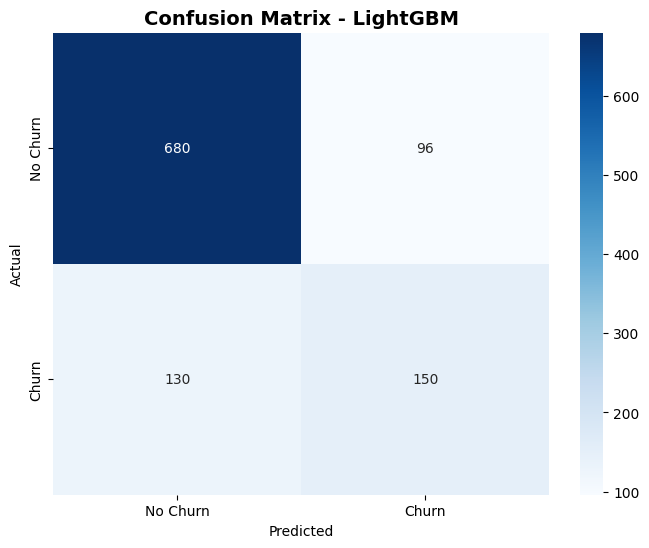

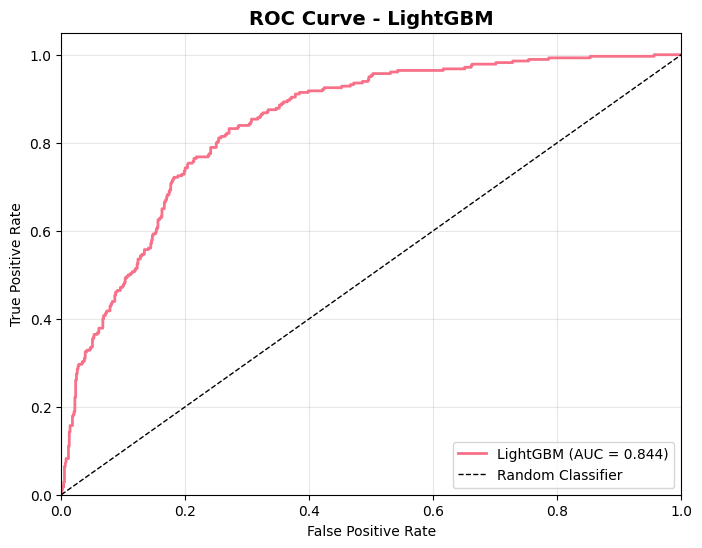

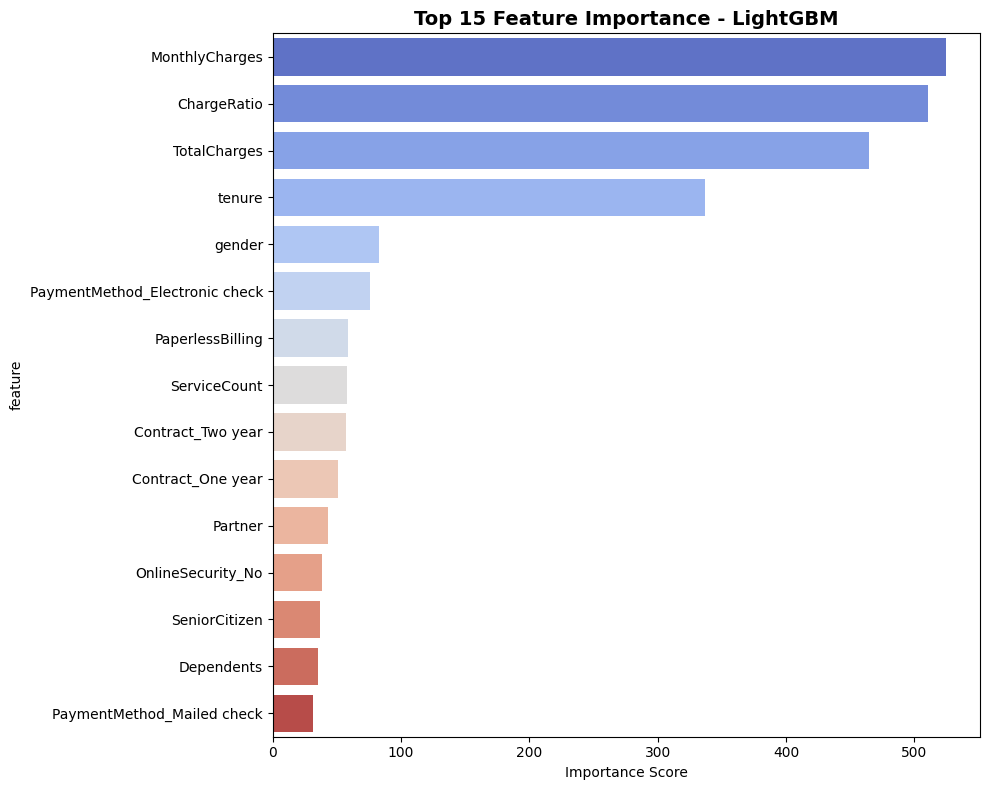

2025/10/21 12:39:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 12:39:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 LightGBM MLflow logging completed! Run ID: e5ee1df29b2b46349205b13adcf6faed


In [ ]:
# Train LightGBM Model
print(" Training LightGBM Model...")

with mlflow.start_run(run_name="lightgbm") as run:
    
    # Initialize and train LightGBM
    lgb_model = lgb.LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        verbose=-1
    )
    lgb_model.fit(X_train, y_train)
    
    print(" LightGBM model trained successfully!")
    
    # Evaluate the model
    lgb_metrics, lgb_pred, lgb_pred_proba = evaluate_model(lgb_model, X_val, y_val, "LightGBM")
    
    # Log parameters
    mlflow.log_param("model_type", "LightGBM")
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("learning_rate", 0.1)
    mlflow.log_param("max_depth", 6)
    mlflow.log_param("random_state", 42)
    mlflow.log_param("train_size", len(X_train))
    mlflow.log_param("val_size", len(X_val))
    
    # Log metrics
    for metric_name, metric_value in lgb_metrics.items():
        mlflow.log_metric(metric_name, metric_value)
    
    # Add tags
    mlflow.set_tags({
        "model_type": "classification",
        "dataset": "telcom",
        "version": "1.0",
        "stage": "advanced",
        "algorithm": "lightgbm"
    })
    
    # Generate and save visualizations
    print("\n Generating LightGBM visualizations...")
    
    # Confusion Matrix
    cm_path = "artifacts/lgb_confusion_matrix.png"
    plot_confusion_matrix(y_val, lgb_pred, "LightGBM", cm_path)
    mlflow.log_artifact(cm_path)
    
    # ROC Curve
    roc_path = "artifacts/lgb_roc_curve.png"
    plot_roc_curve(y_val, lgb_pred_proba, "LightGBM", roc_path)
    mlflow.log_artifact(roc_path)
    
    # Feature Importance Plot
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': lgb_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 8))
    top_features = feature_importance.head(15)
    sns.barplot(data=top_features, x='importance', y='feature', palette='coolwarm')
    plt.title('Top 15 Feature Importance - LightGBM', fontsize=14, fontweight='bold')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    
    fi_path = "artifacts/lgb_feature_importance.png"
    plt.savefig(fi_path, dpi=300, bbox_inches='tight')
    mlflow.log_artifact(fi_path)
    plt.show()
    
    # Log the model
    mlflow.lightgbm.log_model(lgb_model, "model")
    
    lgb_run_id = run.info.run_id
    print(f" LightGBM MLflow logging completed! Run ID: {lgb_run_id}")

# Store results for comparison
lgb_results = {
    'model_name': 'LightGBM',
    'metrics': lgb_metrics,
    'run_id': lgb_run_id,
    'model': lgb_model
}

## 5. Hyperparameter Tuning

In [31]:
# Compare all models to determine best performer for tuning
print("Comparing All Models to Select Best for Hyperparameter Tuning...")

# Collect all results (we'll need to create lr_results first)
lr_results = {
    'model_name': 'Logistic Regression',
    'metrics': lr_metrics,
    'run_id': lr_run_id,
    'model': lr_model
}

all_models = [lr_results, rf_results, xgb_results, lgb_results]

# Create comparison table
comparison_df = pd.DataFrame([
    {
        'Model': model['model_name'],
        'Accuracy': model['metrics']['accuracy'],
        'Precision': model['metrics']['precision'],
        'Recall': model['metrics']['recall'],
        'F1-Score': model['metrics']['f1'],
        'AUC-ROC': model['metrics']['auc_roc']
    }
    for model in all_models
])

print("\n Model Performance Comparison:")
print(comparison_df.round(4))

# Select best model for tuning (prioritizing Recall and AUC-ROC)
# Calculate weighted score: 60% Recall + 40% AUC-ROC
comparison_df['Weighted_Score'] = 0.6 * comparison_df['Recall'] + 0.4 * comparison_df['AUC-ROC']
best_model_idx = comparison_df['Weighted_Score'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']

print(f"\n Best Model Selected for Tuning: {best_model_name}")
print(f"   • Weighted Score (60% Recall + 40% AUC-ROC): {comparison_df.loc[best_model_idx, 'Weighted_Score']:.4f}")
print(f"   • Recall: {comparison_df.loc[best_model_idx, 'Recall']:.4f}")
print(f"   • AUC-ROC: {comparison_df.loc[best_model_idx, 'AUC-ROC']:.4f}")

# Determine which model to tune (assuming XGBoost performs best, but we'll use the actual best)
if best_model_name == "XGBoost":
    model_to_tune = xgb.XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False)
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [4, 6, 8],
        'subsample': [0.8, 0.9, 1.0]
    }
elif best_model_name == "Random Forest":
    model_to_tune = RandomForestClassifier(random_state=42, n_jobs=-1)
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [8, 10, 12, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
elif best_model_name == "LightGBM":
    model_to_tune = lgb.LGBMClassifier(random_state=42, verbose=-1)
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [4, 6, 8],
        'num_leaves': [31, 50, 70]
    }
else:  # Logistic Regression
    model_to_tune = LogisticRegression(random_state=42, max_iter=1000)
    param_grid = {
        'C': [0.1, 1.0, 10.0, 100.0],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    }

print(f"\n Hyperparameter Grid for {best_model_name}:")
for param, values in param_grid.items():
    print(f"   • {param}: {values}")

Comparing All Models to Select Best for Hyperparameter Tuning...

 Model Performance Comparison:
                 Model  Accuracy  Precision  Recall  F1-Score  AUC-ROC
0  Logistic Regression    0.8087     0.6598  0.5750    0.6145   0.8469
1        Random Forest    0.7973     0.6422  0.5321    0.5820   0.8377
2              XGBoost    0.7831     0.6041  0.5286    0.5638   0.8383
3             LightGBM    0.7860     0.6098  0.5357    0.5703   0.8442

 Best Model Selected for Tuning: Logistic Regression
   • Weighted Score (60% Recall + 40% AUC-ROC): 0.6838
   • Recall: 0.5750
   • AUC-ROC: 0.8469

 Hyperparameter Grid for Logistic Regression:
   • C: [0.1, 1.0, 10.0, 100.0]
   • penalty: ['l1', 'l2']
   • solver: ['liblinear', 'saga']


In [ ]:
# Perform Hyperparameter Tuning
print(f" Starting Hyperparameter Tuning for {best_model_name}...")
print(" This may take several minutes...")

with mlflow.start_run(run_name=f"{best_model_name.lower().replace(' ', '_')}_tuned") as run:
    
    # Use RandomizedSearchCV for faster tuning (can switch to GridSearchCV for exhaustive search)
    random_search = RandomizedSearchCV(
        estimator=model_to_tune,
        param_distributions=param_grid,
        n_iter=20,  # Number of parameter settings that are sampled
        cv=5,       # 5-fold cross-validation
        scoring='recall',  # Prioritize recall for churn detection
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    
    # Fit the random search
    random_search.fit(X_train, y_train)
    
    # Get the best model
    best_tuned_model = random_search.best_estimator_
    
    print(" Hyperparameter tuning completed!")
    print(f"\n Best Parameters for {best_model_name}:")
    for param, value in random_search.best_params_.items():
        print(f"   • {param}: {value}")

    print(f"\n Best Cross-Validation Score (Recall): {random_search.best_score_:.4f}")

    # Evaluate tuned model on validation set
    tuned_metrics, tuned_pred, tuned_pred_proba = evaluate_model(
        best_tuned_model, X_val, y_val, f"{best_model_name} (Tuned)"
    )
    
    # Log all parameters (both best params and search params)
    mlflow.log_param("model_type", f"{best_model_name}_tuned")
    mlflow.log_param("tuning_method", "RandomizedSearchCV")
    mlflow.log_param("cv_folds", 5)
    mlflow.log_param("n_iter", 20)
    mlflow.log_param("scoring_metric", "recall")
    mlflow.log_param("best_cv_score", random_search.best_score_)
    
    # Log best parameters
    for param, value in random_search.best_params_.items():
        mlflow.log_param(f"best_{param}", value)
    
    # Log metrics
    for metric_name, metric_value in tuned_metrics.items():
        mlflow.log_metric(metric_name, metric_value)
    
    # Add tags
    mlflow.set_tags({
        "model_type": "classification",
        "dataset": "telcom",
        "version": "1.0",
        "stage": "tuned",
        "algorithm": best_model_name.lower().replace(" ", "_"),
        "tuning_completed": "true"
    })
    
    # Generate and save visualizations
    print(f"\n Generating {best_model_name} (Tuned) visualizations...")
    
    # Confusion Matrix
    cm_path = f"artifacts/{best_model_name.lower().replace(' ', '_')}_tuned_confusion_matrix.png"
    plot_confusion_matrix(y_val, tuned_pred, f"{best_model_name} (Tuned)", cm_path)
    mlflow.log_artifact(cm_path)
    
    # ROC Curve
    roc_path = f"artifacts/{best_model_name.lower().replace(' ', '_')}_tuned_roc_curve.png"
    plot_roc_curve(y_val, tuned_pred_proba, f"{best_model_name} (Tuned)", roc_path)
    mlflow.log_artifact(roc_path)
    
    # Feature Importance Plot (if available)
    if hasattr(best_tuned_model, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'feature': X_train.columns,
            'importance': best_tuned_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        plt.figure(figsize=(10, 8))
        top_features = feature_importance.head(15)
        sns.barplot(data=top_features, x='importance', y='feature', palette='rocket')
        plt.title(f'Top 15 Feature Importance - {best_model_name} (Tuned)', fontsize=14, fontweight='bold')
        plt.xlabel('Importance Score')
        plt.tight_layout()
        
        fi_path = f"artifacts/{best_model_name.lower().replace(' ', '_')}_tuned_feature_importance.png"
        plt.savefig(fi_path, dpi=300, bbox_inches='tight')
        mlflow.log_artifact(fi_path)
        plt.show()
    
    # Log the tuned model
    if best_model_name == "XGBoost":
        mlflow.xgboost.log_model(best_tuned_model, "model")
    elif best_model_name == "LightGBM":
        mlflow.lightgbm.log_model(best_tuned_model, "model")
    else:
        mlflow.sklearn.log_model(best_tuned_model, "model")
    
    tuned_run_id = run.info.run_id
    print(f" Tuned {best_model_name} MLflow logging completed! Run ID: {tuned_run_id}")

# Store tuned results
tuned_results = {
    'model_name': f'{best_model_name} (Tuned)',
    'metrics': tuned_metrics,
    'run_id': tuned_run_id,
    'model': best_tuned_model,
    'best_params': random_search.best_params_,
    'cv_score': random_search.best_score_
}

 Starting Hyperparameter Tuning for Logistic Regression...
 This may take several minutes...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
